In [33]:
import numpy as np
import pytest
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from treeple.datasets import make_trunk_classification

from treeple.stats import NeuroExplainableOptimalFIT

## MNIST 3/5 classification

### Load data

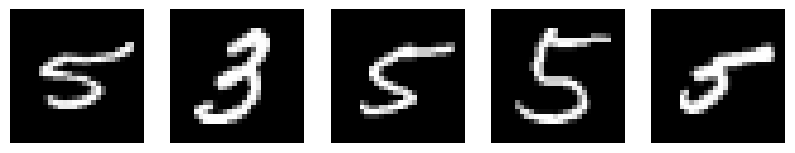

In [32]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Filter the dataset for labels 3 and 5
indices = np.where((mnist.targets == 3) | (mnist.targets == 5))[0]
filtered_mnist = torch.utils.data.Subset(mnist, indices)

# Function to display images
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        image, label = dataset[np.random.randint(len(dataset))]
        axes[i].imshow(image.squeeze(), cmap='gray')
        # axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Display random images
show_images(filtered_mnist)


In [5]:
X_mnist = []
y_mnist = []
for image, label in filtered_mnist:
    X_mnist.append(image.numpy().flatten())
    y_mnist.append(label)
X_mnist = np.array(X_mnist)
y_mnist = np.array(y_mnist)
print(X_mnist.shape, y_mnist.shape)

X_train_mnist, X_temp_mnist, y_train_mnist, y_temp_mnist = train_test_split(X_mnist, y_mnist, test_size=0.4, random_state=0)
X_val_mnist, X_test_mnist, y_val_mnist, y_test_mnist = train_test_split(X_temp_mnist, y_temp_mnist, test_size=0.5, random_state=0)

print(X_train_mnist.shape, X_val_mnist.shape, X_test_mnist.shape)
print(y_train_mnist.shape, y_val_mnist.shape, y_test_mnist.shape)

(11552, 784) (11552,)
(6931, 784) (2310, 784) (2311, 784)
(6931,) (2310,) (2311,)


### Build NEOFIT explainer to test feature importance

In [19]:
neofit = NeuroExplainableOptimalFIT(n_estimators=5000, n_permutations=100000, clf_type="MORF")

In [20]:
p_values, imp_features, _ = neofit.get_significant_features(X_train_mnist, y_train_mnist)

Found 192 significant features out of 784
Significant features: [ 67  68  69  70  71  72  73  74  75  76  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 118 119 120 121 122 123 124 129 130 131 132
 133 134 135 145 146 147 148 149 150 158 159 160 161 162 163 164 173 174
 175 176 177 186 187 188 189 190 191 192 201 202 203 204 205 214 215 216
 217 218 219 220 229 230 231 232 233 234 235 241 242 243 244 245 246 247
 248 257 258 259 260 261 262 263 267 268 269 270 271 272 273 274 275 276
 286 287 288 289 290 291 295 296 297 298 299 300 301 302 303 304 314 315
 316 317 318 319 323 324 325 326 327 328 329 330 331 332 342 343 344 345
 346 351 352 353 354 355 356 357 358 359 370 371 372 373 383 384 385 386
 387 398 399 400 414 415 427 442 443 470 471 480 507 508 528 535 536 556
 563 564 591 592 619 620 621 648 649 676 677 705]


### Visualize important features

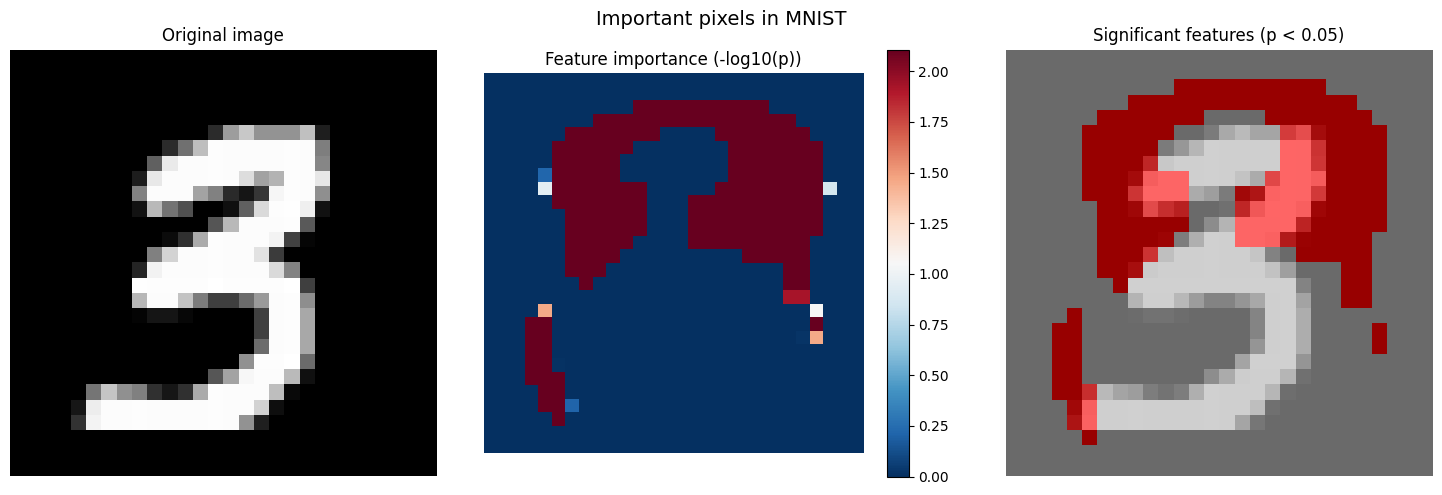

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_feature_importance(X_train_mnist, p_values, alpha=0.05, sample_idx=None, figsize=(15, 5)):
    """Visualize the feature importance of a sample image in MNIST"""
    if sample_idx is None:
        sample_idx = np.random.randint(X_train_mnist.shape[0])
    
    sample_image = X_train_mnist[sample_idx]
    
    log_p = -np.log10(p_values)
    imp_features = p_values < alpha

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle('Important pixels in MNIST', fontsize=14)
    
    axes[0].imshow(sample_image.reshape(28, 28), cmap='gray')
    axes[0].set_title('Original image')
    axes[0].axis('off')

    log_p_map = log_p.reshape(28, 28)
    im = axes[1].imshow(log_p_map, cmap='RdBu_r')
    axes[1].set_title('Feature importance (-log10(p))')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1])
    
    significance_map = np.zeros((28, 28, 4))
    significance_map[..., 3] = 1  
    
    significance_map[imp_features.reshape(28, 28)] = [1, 0, 0, 1]  
    significance_map[~imp_features.reshape(28, 28)] = [0.7, 0.7, 0.7, 1]  
    
    axes[2].imshow(sample_image.reshape(28, 28), cmap='gray')
    axes[2].imshow(significance_map, alpha=0.6)
    axes[2].set_title('Significant features (p < 0.05)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_feature_importance(X_train_mnist, p_values)

## Trunk simulation

### Load data

In [40]:
n_samples = 1000
n_dim = 784
X_trunk, y_trunk = make_trunk_classification(n_samples=n_samples, n_dim=n_dim, n_informative=600, seed=0)
print(X_trunk.shape, y_trunk.shape)

X_train_trunk, X_temp_trunk, y_train_trunk, y_temp_trunk = train_test_split(X_trunk, y_trunk, test_size=0.4, random_state=0)
X_val_trunk, X_test_trunk, y_val_trunk, y_test_trunk = train_test_split(X_temp_trunk, y_temp_trunk, test_size=0.5, random_state=0)

print(X_train_trunk.shape, X_val_trunk.shape, X_test_trunk.shape)
print(y_train_trunk.shape, y_val_trunk.shape, y_test_trunk.shape)


(1000, 784) (1000,)
(600, 784) (200, 784) (200, 784)
(600,) (200,) (200,)


### Build NEOFIT explainer to test feature importance

In [41]:
neofit = NeuroExplainableOptimalFIT(n_estimators=5000, n_permutations=100000, clf_type="SPORF")

In [42]:
p_values, imp_features, _ = neofit.get_significant_features(X_train_trunk, y_train_trunk)

Found 21 significant features out of 784
Significant features: [  0   1   2   3   4   5   6   7   8   9  11  12  17  27  28  45  68  73
 105 122 215]


### Visualize important features

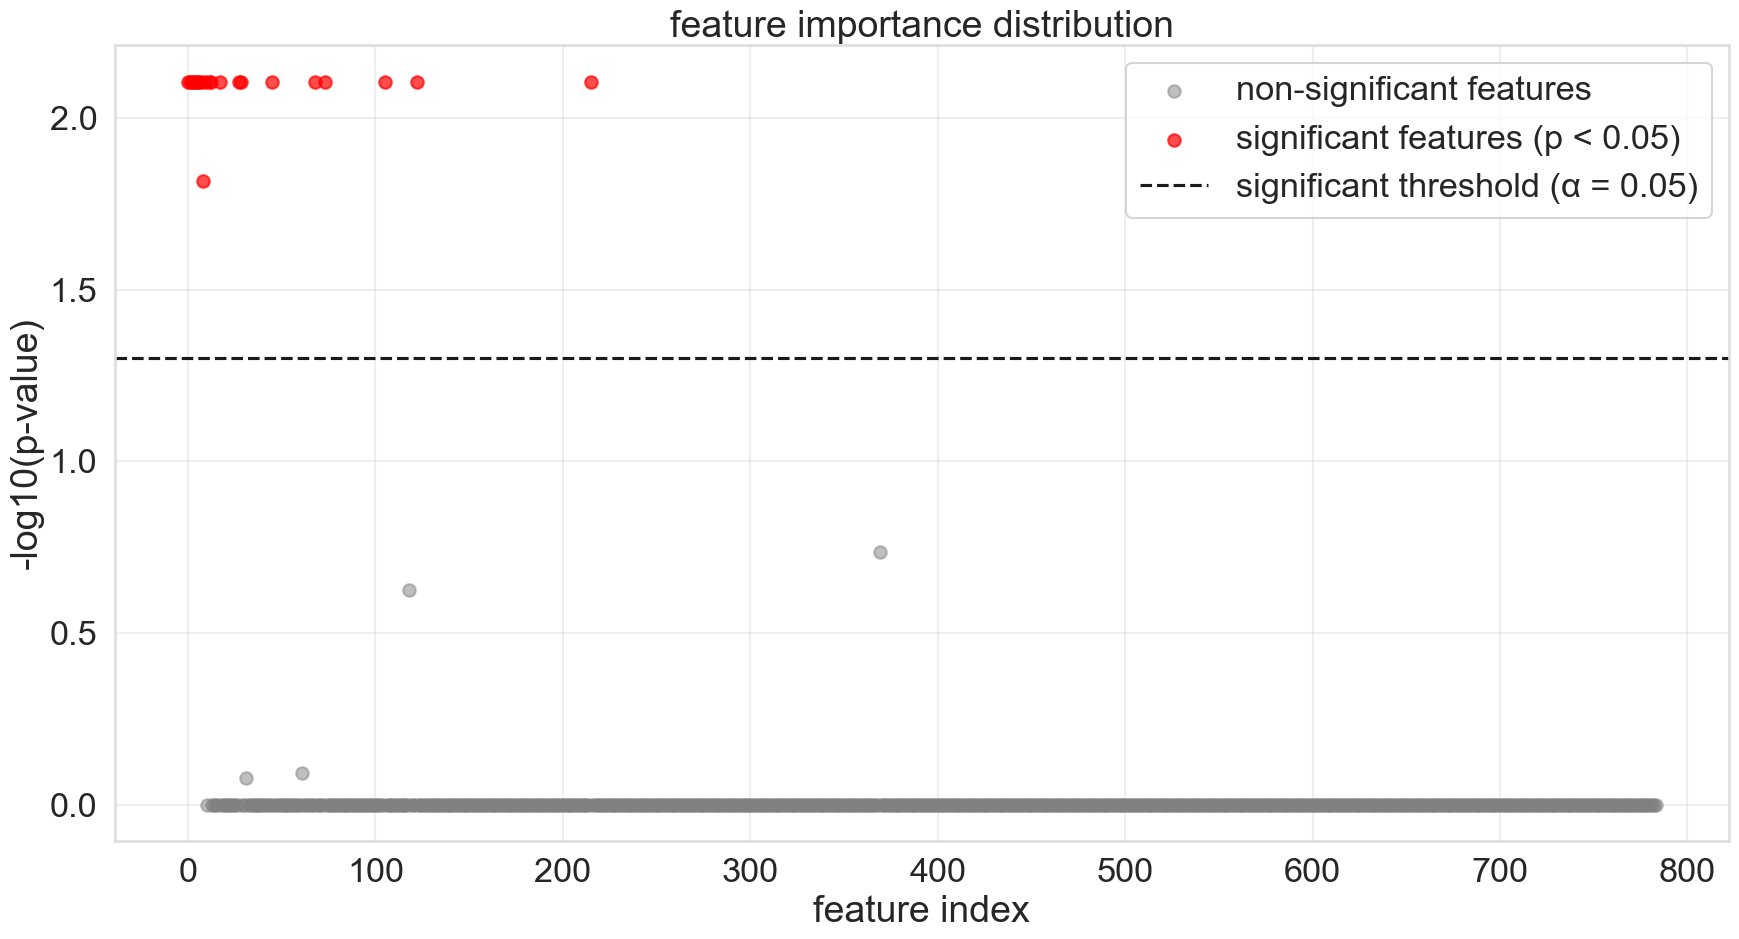

In [48]:
def plot_feature_significance(p_values, alpha=0.05, figsize=(18, 10)):
    """Visualize the feature significance of a sample image in trunk"""
    log_p = -np.log10(p_values)
    significant = p_values < alpha
    
    plt.figure(figsize=figsize)
    
    plt.scatter(np.arange(len(p_values))[~significant], 
               log_p[~significant], 
               c='gray', alpha=0.5, 
               label='non-significant features')
    plt.scatter(np.arange(len(p_values))[significant], 
               log_p[significant], 
               c='red', alpha=0.7,
               label='significant features (p < 0.05)')
    
    threshold = -np.log10(alpha)
    plt.axhline(y=threshold, color='k', linestyle='--', 
                label=f'significant threshold (α = {alpha})')
    
    plt.xlabel('feature index')
    plt.ylabel('-log10(p-value)')
    plt.title('feature importance distribution')
    
    plt.legend()
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_feature_significance(p_values)